In [1]:
#libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats 
import random


In [2]:
#Classes to process the data
class State(object):
  def __init__(self, state, new_cases_per_100k, dem_margin):
    self.state = state
    self.cases = new_cases_per_100k
    self.dem_margin = dem_margin
  
  def toString(self):
    return f"State: {self.state}, Average New Weekly Cases Per 100k: {self.cases}, Democratic Margin of Victory: {self.dem_margin}"

#Container class to hold the data
class Container(object):
  def __init__(self):
    self.states = []
  
  def add(self, state):
    self.states.append(state)
  
  def toString(self):
    string = ''
    for item in self.states:
      string += item.toString() + "\n"
    return string

class StateCovidData(object):
  def __init__(self, state):
    self.state = state
    self.cases = 0
    self.point_count = 0
    self.sum_of_cases = 0
  
  def add(self, new_cases_per_100k):
    self.point_count += 1
    self.sum_of_cases += new_cases_per_100k
    self.cases = self.sum_of_cases/self.point_count
    
  def toString(self):
    return f"{self.state}, Average New Weekly Cases Per 100k: {self.cases}"

In [3]:
#Covid Data 
cov_key = "2c3b686a09214915b1471a2f0df00d20"
cov_url = "https://api.covidactnow.org/v2/states.timeseries.csv?apiKey="+cov_key

#Create dataframe
df = pd.read_csv(cov_url)

In [4]:
covid_data = df.loc[:, ["date", "state", "metrics.weeklyCovidAdmissionsPer100k"]]

#Take the average of all the data for each state and add it to a dictionary with the state as the key
state_covid_data = {}

for row in covid_data.iterrows():
  #continue if nan 
  if pd.isna(row[1]["metrics.weeklyCovidAdmissionsPer100k"]):
    continue

  if row[1].state in state_covid_data:
    state_covid_data[row[1].state].add(row[1]["metrics.weeklyCovidAdmissionsPer100k"])
  else:
    state_covid_data[row[1].state] = StateCovidData(row[1].state)
    state_covid_data[row[1].state].add(row[1]["metrics.weeklyCovidAdmissionsPer100k"])


In [5]:

#Voting Data 
vote_data = pd.read_csv(r'../data/pop_vote2.csv')

#Make a dictionary with the states as keys and the democratic margin as values
vote_dict_names = dict(zip(vote_data['state'], vote_data['dem_this_margin']))

#Dict of abbreviations and full names
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
#Reverse the list to use the name to find the variables 
#inv_map = {v: k for k, v in my_map.items()}
state_dict = {v:k for k, v in state_dict.items()}

vote_dict_abbrev = {}

#Rename the states to their abrev
for item in vote_dict_names:
    try:
        abbrev = state_dict[item]
        vote_dict_abbrev[abbrev] = vote_dict_names[item]
    except:
        continue

In [6]:
#Put all the data into a container object
container = Container()

for item in vote_dict_abbrev:
    state_obj = State(state=item, dem_margin=vote_dict_abbrev[item], new_cases_per_100k=state_covid_data[item].cases)
    container.add(state_obj)

In [13]:
democratic = []
republic = []

for item in container.states:
    if item.cases == None:
        continue
    else:
        if float(item.dem_margin.replace("%", "")) > 0:
            democratic.append(item)
        else:
            republic.append(item)

In [15]:
def df_mean(list):
    num = 0
    for i in list:
        num += i.cases
    num /= len(list)
    return num

In [18]:
dem_mean = df_mean(democratic)
rep_mean = df_mean(republic)
print(f'democratic mean is {dem_mean} and republic mean is {rep_mean}')
dif = rep_mean - dem_mean
print(f'The difference is {dif}')
likelihood = (rep_mean - dem_mean) / 100000 * 100 
print(f'It is {likelihood}% more likely to get covid in a republican state')

democratic mean is 12.00396048468123 and republic mean is 15.280893146597279
The difference is 3.2769326619160495
It is 0.0032769326619160495% more likely to get covid in a republican state


In [7]:
#Make a plot for the data 

# Make two arrays, one for the dem_margin_vic and one for the cases 
dem_margin = []
cases_per_100k = []

for item in container.states:
  if item.cases == None: 
    continue
  else: 
    cases_per_100k.append(item.cases)
    dem_margin.append(item.dem_margin)

dem_float_arr = []

for item in dem_margin:
   dem_float_arr.append(float(item.replace("%", "")))


Correlation: -0.5506990354108996, P Value of Correlation: 3.416449432157325e-05
slope: -0.0980890190395498, and intercept: 13.414467935391343


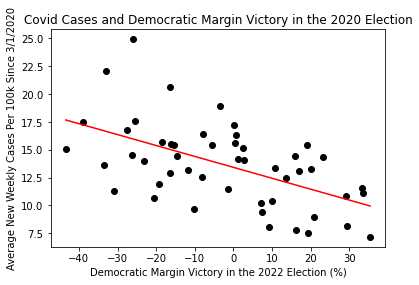

In [8]:
# linear line     
cases = pd.DataFrame(cases_per_100k).values
dem_margin = pd.DataFrame(dem_float_arr).values

x = dem_float_arr
y = cases_per_100k

# correlation
correlation, p_value_correlation = scipy.stats.pearsonr(x, y)
print(f"Correlation: {correlation}, P Value of Correlation: {p_value_correlation}")

# polyfit of 3rd degree, change the number in the polyfit function to change the degree of fit
fit, cov = np.polyfit(x, y, 1, cov=True)
print(f"slope: {fit[0]}, and intercept: {fit[1]}")

x_fit = np.linspace(np.min(dem_margin),np.max(dem_margin))
poly_fit = np.polyval(fit,x_fit)

plt.plot(x_fit, poly_fit, color = 'red')

plt.ylabel("Average New Weekly Cases Per 100k Since 3/1/2020")
plt.xlabel("Democratic Margin Victory in the 2022 Election (%)")
plt.title("Covid Cases and Democratic Margin Victory in the 2020 Election")
plt.scatter(x, y, color='black')
plt.savefig("covid_cases_and_dem_margin.png", dpi=500)
plt.show()

In [9]:
# cross_validation
def cross_validation(remove_nums, dataSetX, dataSetY, iteration):
    slope_array = []
    for i in range (iteration):
        copy_X = dataSetX.copy()
        copy_Y = dataSetY.copy()
        remove_indexs = random.sample(range(len(copy_X)), remove_nums)
        for i in range(len(remove_indexs)):
            copy_X.pop(remove_indexs[i]-i) #Because the list is getting smaller, we need to subtract i from the index
            copy_Y.pop(remove_indexs[i]-i)  
        fit = np.polyfit(copy_X, copy_Y, 1) 
        slope_array.append(fit)
    return slope_array

Mean Slope: -0.09681412107322329, Mean Intercept: 13.376727055569015, Std Slope: 0.006793859650234753, Std Intercept: 0.11141411324531499))


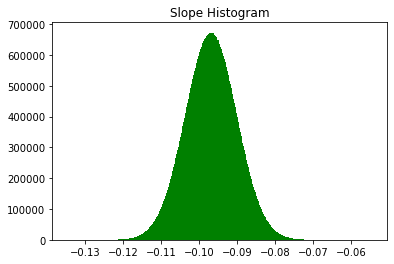

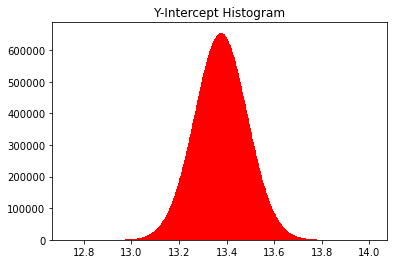

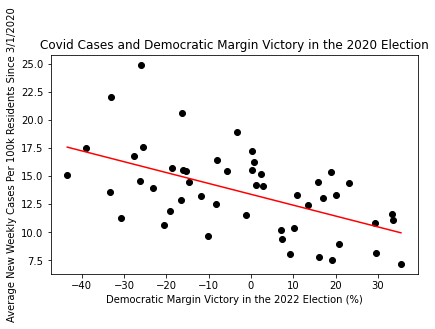

In [10]:
slope_array = cross_validation(3, x, y, 10)
slope = []
intercept = []
for i in slope_array:
    slope.append(i[0])
    intercept.append(i[1])
    
mean_slope = np.mean(slope)
mean_intercept = np.mean(intercept)

std_intercept = np.std(intercept)
std_slope = np.std(slope)

print(f"Mean Slope: {mean_slope}, Mean Intercept: {mean_intercept}, Std Slope: {std_slope}, Std Intercept: {std_intercept}))")

n = 100000000
slope_hist = np.random.normal(mean_slope, std_slope, n)
intercept_hist = np.random.normal(mean_intercept, std_intercept, n)

bins = 700
plt.hist(slope_hist, bins=bins, color='green')
plt.title("Slope Histogram")
plt.savefig("Slope_Histogram", dpi=500)
plt.show()
plt.hist(intercept_hist, bins=bins, color='red')
plt.title("Y-Intercept Histogram")
plt.savefig("Y_Intercept_Histogram", dpi=500)
plt.show()
plt.figure(1)

x_fit = np.linspace(np.min(x),np.max(x))
fit = [mean_slope, mean_intercept]
poly_fit = np.polyval(fit,x_fit)
plt.plot(x_fit, poly_fit, color = 'red')

plt.xlabel("Democratic Margin Victory in the 2022 Election (%)")
plt.ylabel("Average New Weekly Cases Per 100k Residents Since 3/1/2020")
plt.title("Covid Cases and Democratic Margin Victory in the 2020 Election")
plt.scatter(x, y, color='black')
# the plot is cut off, need to work on output
plt.tight_layout()
plt.savefig("cross_validation_covid_cases_and_dem_margin.pdf", dpi=150)